# Layerwise Proxy Analysis

Purpose: select a model by GT rank (top or bottom) under a given task/search space, then compute per-layer FLOPs, SWAP, NASWOT, ZiCo-like grad ratio, and visualize. Text in charts is English; code comments in Chinese.

Steps:
1. Configure task/search space and rank (top-k or bottom-k).
2. Load TransNASBench API, sort architectures by GT, pick target.
3. Build model, run a small batch to collect per-layer metrics.
4. Plot per-layer metrics.

> Note: Layerwise ZiCo here uses per-layer mean(NSR) from a single backward pass; layerwise NASWOT uses per-ReLU logdet; SWAP counts unique sign patterns per layer; FLOPs uses fvcore by-module stats.


In [1]:
import sys
from pathlib import Path
import warnings
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict


# 项目路径（notebook 下用 cwd）
CURRENT_DIR = Path.cwd()
ROOT_DIR = CURRENT_DIR.parent
NASLIB_ROOT = ROOT_DIR / "NASLib"

sys.path.insert(0, str(ROOT_DIR))
sys.path.insert(0, str(NASLIB_ROOT))

# 忽略冗余警告
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*unsupported.*")
warnings.filterwarnings("ignore", message=".*Unsupported.*")

from proxy_TransNAS.utils.load_model import (
    load_transbench_classes,
    load_transbench_api,
    make_train_loader,
    truncate_loader,
    set_op_indices_from_str,
    get_metric_name,
)
from proxy_TransNAS.proxies.flops import compute_flops  # 全局 FLOPs
from proxy_TransNAS.proxies.naswot import compute_naswot_score, network_weight_gaussian_init  # 全局 NASWOT
from proxy_TransNAS.proxies.swap import compute_swap_score  # 全局 SWAP
from proxy_TransNAS.proxies.zico import compute_zico_score, getgrad_safe  # 全局 ZiCo 与梯度收集
from fvcore.nn import FlopCountAnalysis  # 逐层 FLOPs



In [2]:
# 配置区域（根据需要修改）
TASK = "segmentsemantic"          # autoencoder / segmentsemantic / normal
SEARCH_SPACE = "macro"        # micro / macro
ARCH_STR = "64-43111-basic"                # 手动指定起始架构（如 "64-33114-basic"）；None 时从 FLOPs 最小开始
ARCH_COUNT = 15                 # 从起始架构起，按 FLOPs 排序取多少个
CSV_PATH = ROOT_DIR / "proxy_TransNAS" / "flops_lookup" / f"flops_{SEARCH_SPACE}_{TASK}.csv"
DATA_ROOT = NASLIB_ROOT / "naslib" / "data"  # 数据根
BATCH_SIZE = 8                 # DataLoader batch，越小越省显存
MAXBATCH = 2                   # 只取前几个 batch
SEED = 42                      # 随机种子
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ENCODER_DECODER_SPLIT = None   # 手动指定分界层索引；None 时自动按层名包含"decoder"检测



In [3]:
# 准备数据与 API
torch.manual_seed(SEED)
TransMicro, TransMacro, graph_module = load_transbench_classes()
Metric = graph_module.Metric

data_root = Path(DATA_ROOT).resolve()
dataset_api = load_transbench_api(data_root, TASK)
api = dataset_api["api"]

# 选择搜索空间实例
target_ss_list = api.all_arch_dict[SEARCH_SPACE]
if SEARCH_SPACE == "micro":
    if TASK == "segmentsemantic":
        ss = TransMicro(dataset=TASK, create_graph=True, n_classes=17)
    else:
        ss = TransMicro(dataset=TASK, create_graph=True)
else:
    ss = TransMacro(dataset=TASK, create_graph=True)

# 读取 FLOPs CSV，按 flops 升序
csv_path = Path(CSV_PATH).resolve()
assert csv_path.exists(), f"CSV 不存在: {csv_path}"
flookup = pd.read_csv(csv_path)
flookup = flookup.sort_values(by="flops").reset_index(drop=True)

if ARCH_STR is None:
    start_idx = 0
else:
    hit = flookup.index[flookup["arch_str"] == ARCH_STR].tolist()
    assert len(hit) > 0, f"ARCH_STR 未在 CSV 中找到: {ARCH_STR}"
    start_idx = hit[0]

arch_slice = flookup.iloc[start_idx:start_idx + ARCH_COUNT].copy()
print(f"选取区间: [{start_idx}, {start_idx + len(arch_slice)}) / {len(flookup)}")
print(arch_slice[["arch_str", "flops", "gt"]])



选取区间: [1194, 1209) / 3256
             arch_str         flops         gt
1194   64-43111-basic  3.755934e+09  94.161469
1195   64-32311-basic  3.760521e+09  94.278709
1196   64-31231-basic  3.760783e+09  94.360626
1197   64-31123-basic  3.761046e+09  94.272537
1198   64-44113-basic  3.764486e+09  94.248405
1199   64-41413-basic  3.765010e+09  94.297112
1200   64-41143-basic  3.765535e+09  94.378632
1201   64-14413-basic  3.766059e+09  94.386772
1202   64-14143-basic  3.766583e+09  94.496101
1203   64-11443-basic  3.767632e+09  94.501572
1204    64-3322-basic  3.777331e+09  93.950066
1205  64-411133-basic  3.796582e+09  94.450760
1206  64-141133-basic  3.797631e+09  94.591377
1207  64-114133-basic  3.798680e+09  94.645485
1208  64-111433-basic  3.799728e+09  94.599716


In [4]:
# 构建 DataLoader（仅取少量 batch 以控制显存）
train_loader = make_train_loader(TASK, data_root, BATCH_SIZE, SEED)
train_batches = truncate_loader(train_loader, MAXBATCH)
assert len(train_batches) > 0, "DataLoader is empty"
inputs, labels = train_batches[0]
inputs = inputs.to(DEVICE)
labels = labels.to(DEVICE)

# 辅助函数：根据指定架构字符串重新构建模型

def build_model_for_arch(arch_str):  # 每次新建，避免权重被前一步修改
    g = ss.clone()
    g = set_op_indices_from_str(SEARCH_SPACE, g, arch_str)
    g.parse()
    return g.to(DEVICE)



In [5]:
# # 全局 proxy 分数（与运行脚本一致的实现）
# # 每个 proxy 单独构建模型，避免权重修改互相影响

# global_scores = {}

# # FLOPs
# m_flops = build_model()
# global_scores["FLOPs"] = compute_flops(m_flops, train_batches, DEVICE)
# del m_flops; torch.cuda.empty_cache()

# # NASWOT
# m_naswot = build_model()
# global_scores["NASWOT"] = compute_naswot_score(m_naswot, train_batches, DEVICE)
# del m_naswot; torch.cuda.empty_cache()

# # SWAP
# m_swap = build_model()
# global_scores["SWAP"] = compute_swap_score(m_swap, train_batches, DEVICE)
# del m_swap; torch.cuda.empty_cache()

# # ZiCo
# m_zico = build_model()
# loss_fn = torch.nn.L1Loss() if TASK in ["autoencoder", "normal"] else (
#     torch.nn.CrossEntropyLoss()
# )
# global_scores["ZiCo"] = compute_zico_score(m_zico, train_batches, loss_fn, DEVICE)
# del m_zico; torch.cuda.empty_cache()

# global_scores


In [ ]:
import numpy.linalg as LA

# 计算单个架构的逐层 proxies（FLOPs/NASWOT/SWAP/ZiCo），返回合并后的 DataFrame

def layer_sort_key(name: str):
    s = str(name)
    if "encoder" in s:
        return (0, s)
    if "decoder" in s:
        return (2, s)
    return (1, s)

def compute_layerwise_proxies(arch_str, batches):
    inputs, labels = batches[0]
    inputs = inputs.to(DEVICE)

    # FLOPs by_module
    model_layer = build_model_for_arch(arch_str)
    model_layer.eval()
    with torch.no_grad():
        flop_analyzer = FlopCountAnalysis(model_layer, inputs[:1])
        flop_analyzer.unsupported_ops_warnings(False)
        flop_analyzer.uncalled_modules_warnings(False)
        by_module = flop_analyzer.by_module()
    flops_df = pd.DataFrame(list(by_module.items()), columns=["layer", "flops"])
    del model_layer; torch.cuda.empty_cache()

    # NASWOT per ReLU
    model_nw = build_model_for_arch(arch_str)
    model_nw.eval()
    network_weight_gaussian_init(model_nw)
    naswot_records = []
    def make_hook(name):
        def hook(module, inp, out):
            x = inp[0].view(inp[0].size(0), -1)
            s = (x > 0).float().cpu().numpy()
            K = s @ s.T + (1 - s) @ (1 - s.T)
            try:
                _, ld = LA.slogdet(K)
                naswot_records.append((name, float(ld)))
            except Exception:
                naswot_records.append((name, float("nan")))
        return hook
    handles = [m.register_forward_hook(make_hook(n))
               for n, m in model_nw.named_modules()
               if isinstance(m, (torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.PReLU))]
    with torch.no_grad():
        _ = model_nw(inputs)
    for h in handles: h.remove()
    del model_nw; torch.cuda.empty_cache()
    naswot_df = pd.DataFrame(naswot_records, columns=["layer", "naswot_logdet"])

    # SWAP per ReLU（与 swap.py 一致：按神经元模式计数）
    model_sw = build_model_for_arch(arch_str)
    model_sw.eval()
    swap_records = []
    def make_swap_hook(name):
        def hook(module, inp, out):
            x = out.view(out.size(0), -1)
            sign = torch.sign(x).cpu().t()  # (neurons, batch)
            unique_rows = torch.unique(sign, dim=0).shape[0]
            swap_records.append((name, int(unique_rows)))
        return hook
    handles = [m.register_forward_hook(make_swap_hook(n))
               for n, m in model_sw.named_modules()
               if isinstance(m, (torch.nn.ReLU, torch.nn.LeakyReLU, torch.nn.PReLU))]
    with torch.no_grad():
        _ = model_sw(inputs)
    for h in handles: h.remove()
    del model_sw; torch.cuda.empty_cache()
    swap_df = pd.DataFrame(swap_records, columns=["layer", "swap_unique"])

    # ZiCo per layer
    model_zc = build_model_for_arch(arch_str)
    model_zc.train()
    if TASK in ["autoencoder", "normal"]:
        loss_fn = torch.nn.L1Loss()
    elif TASK == "segmentsemantic":
        loss_fn = torch.nn.CrossEntropyLoss()
    else:
        loss_fn = torch.nn.CrossEntropyLoss()

    grad_dict = {}
    for step_i, (xb, yb) in enumerate(batches):
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)

        # 确保标签类型正确
        if isinstance(loss_fn, torch.nn.CrossEntropyLoss) or isinstance(loss_fn, torch.nn.NLLLoss):
            yb = yb.long()
        elif isinstance(loss_fn, torch.nn.BCELoss) or isinstance(loss_fn, torch.nn.BCEWithLogitsLoss):
            yb = yb.float()
            
        model_zc.zero_grad()
        logits = model_zc(xb)
        yb_ce = yb.squeeze(1) if (yb.ndim == 4 and yb.shape[1] == 1) else yb
        loss = loss_fn(logits, yb_ce)
        loss.backward()
        grad_dict = getgrad_safe(model_zc, grad_dict, step_i)
        model_zc.zero_grad(set_to_none=True)

    zico_records = []
    for name, grads in grad_dict.items():
        arr = np.array(grads)
        grad_std = np.std(arr, axis=0)
        nz = np.nonzero(grad_std)[0]
        if len(nz) == 0:
            zico_records.append((name, np.nan)); continue
        grad_mean_abs = np.mean(np.abs(arr), axis=0)
        tmpsum = np.mean(grad_mean_abs[nz] / grad_std[nz])
        zico_records.append((name, float(np.log(tmpsum)) if tmpsum > 0 else np.nan))

    del model_zc; torch.cuda.empty_cache()
    zico_df = pd.DataFrame(zico_records, columns=["layer", "zico_log_nsr"])

    # 合并并排序
    merged = flops_df.merge(naswot_df, on="layer", how="outer")
    merged = merged.merge(swap_df, on="layer", how="outer")
    merged = merged.merge(zico_df, on="layer", how="outer")
    merged = merged.fillna(0)
    merged = merged.assign(_order=merged["layer"].apply(layer_sort_key))
    merged = merged.sort_values(by="_order").drop(columns=["_order"]).reset_index(drop=True)

    # 释放临时张量/引用
    del inputs, labels
    torch.cuda.empty_cache()
    return merged


In [7]:
# 批处理所选架构：仅逐层 proxies（不计算全局 proxy）
results = []  # 每个元素: {arch_str, flops, gt, merged}
for _, row in arch_slice.iterrows():
    arch = row["arch_str"]
    flp = row["flops"]
    gt = row["gt"]
    merged = compute_layerwise_proxies(arch, train_batches)
    results.append({"arch_str": arch, "flops": flp, "gt": gt, "merged": merged})
    print(f"done: {arch}, flops={flp:.1f}, gt={gt:.4f}")
    torch.cuda.empty_cache()  # 每个架构结束后清理


RuntimeError: expected scalar type Long but found Byte

In [ ]:
# 调试：查看合并后的层名和分界（使用首个架构）
if len(results) > 0:
    merged_preview = results[0]["merged"].reset_index(drop=True)
    decoder_mask = merged_preview["layer"].astype(str).str.contains("decoder", case=False, na=False)
    first_decoder_idx = int(decoder_mask.idxmax()) if decoder_mask.any() else None
    print("Total layers (first arch):", len(merged_preview))
    print("First decoder idx:", first_decoder_idx)
    if first_decoder_idx is not None:
        print(merged_preview.loc[first_decoder_idx, "layer"])


Total layers (first arch): 214
First decoder idx: 158
None-edge(1,2).model.decoder


C:\Users\Lem17\AppData\Local\Temp\ipykernel_3784\3740881234.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("turbo")


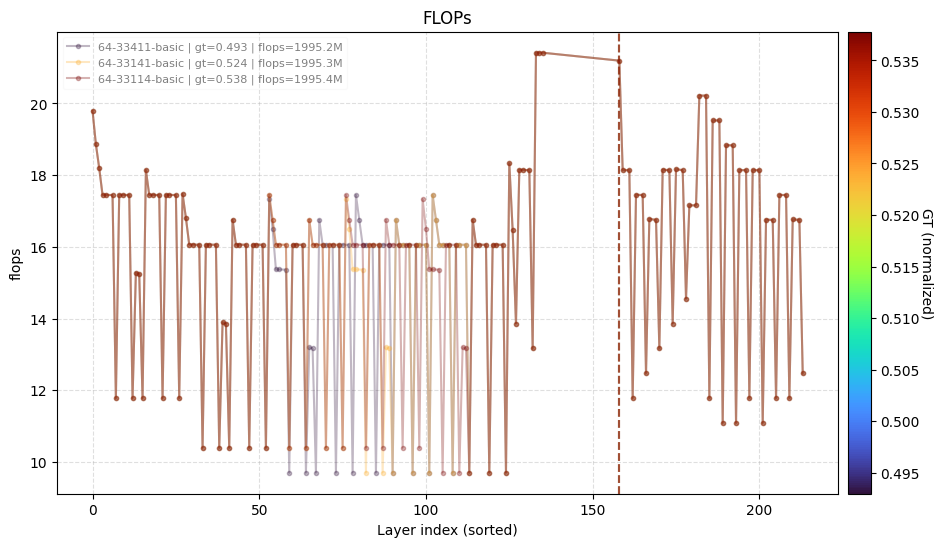

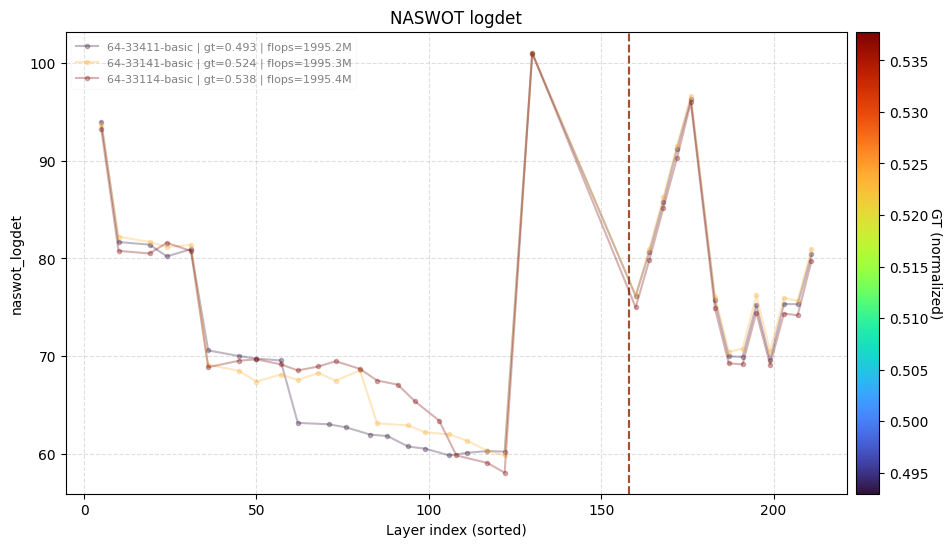

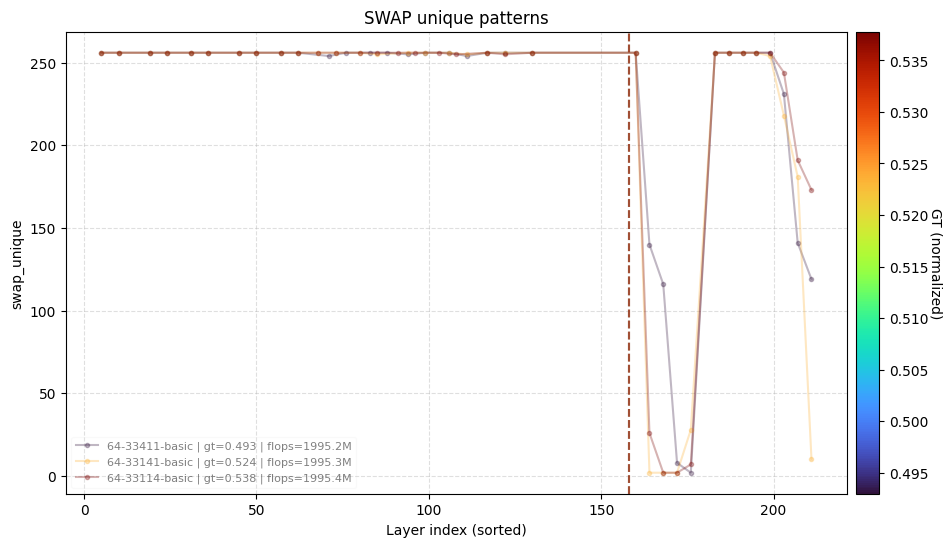

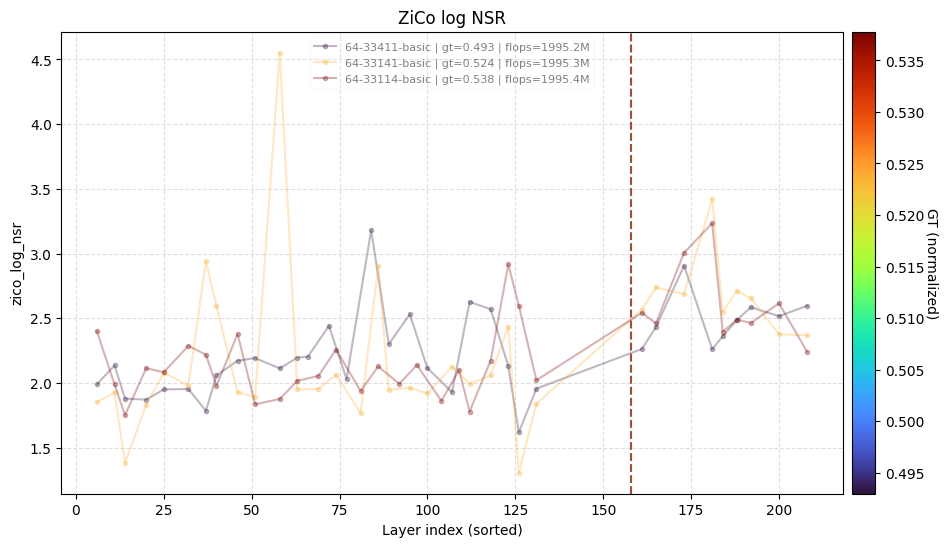

In [ ]:
# 可视化：四张图，每张对应一个 proxy，包含多架构曲线（过滤 0 和 NaN）
import matplotlib.cm as cm
import matplotlib.colors as mcolors

proxies = [
    ("flops", "FLOPs"),
    ("naswot_logdet", "NASWOT logdet"),
    ("swap_unique", "SWAP unique patterns"),
    ("zico_log_nsr", "ZiCo log NSR"),
]

gts = [r["gt"] for r in results]
flps = [r["flops"] for r in results]
norm_gt = mcolors.Normalize(vmin=min(gts), vmax=max(gts))
norm_fp = mcolors.Normalize(vmin=min(flps), vmax=max(flps))
cmap = cm.get_cmap("turbo")

for col, title in proxies:
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    any_line = False
    for r in results:
        merged = r["merged"].reset_index(drop=True)
        x = np.arange(len(merged))
        vals = merged[col].to_numpy().astype(float)

        # 若是 FLOPs，先做 log10，过滤非正数
        if col == "flops":
            # 仅对 >0 的值取 log10，非正/NaN 视为 0
            log_vals = np.full_like(vals, np.nan, dtype=float)
            positive_mask = np.isfinite(vals) & (vals > 0)
            log_vals[positive_mask] = np.log(vals[positive_mask])
            vals = log_vals  # 后续用 log 后的值

        # 过滤掉 0 和 NaN，只保留非零有限值
        mask = np.isfinite(vals) & (vals != 0)
        if not mask.any():
            print(f"[skip {col}] {r['arch_str']} 全为空")
            continue

        x_nonzero = x[mask]
        y_nonzero = vals[mask]
        any_line = True

        color = cmap(norm_gt(r["gt"]))
        alpha = 0.3
        label = f"{r['arch_str']} | gt={r['gt']:.3f} | flops={r['flops']/1e6:.1f}M"
        # 连线 + marker，只有非零点
        ax.plot(x_nonzero, y_nonzero, color=color, alpha=alpha, label=label,
                marker="o", markersize=3, linestyle="-")

        # encoder/decoder 分界线，使用该模型的颜色、虚线、半透明
        decoder_mask = merged["layer"].astype(str).str.contains("decoder", case=False, na=False)
        if decoder_mask.any():
            split_idx = int(decoder_mask.idxmax())
            ax.axvline(split_idx, color=color, linestyle="--", alpha=0.5)

    plt.title(title)
    plt.xlabel("Layer index (sorted)")
    plt.ylabel(col)
    plt.grid(True, linestyle='--', alpha=0.4)
    if any_line:
        leg = plt.legend(fontsize=8, loc="best", framealpha=0.1)
        for text in leg.get_texts():
            text.set_alpha(0.5)   # 这里 0.0~1.0，越小越透明
    sm = cm.ScalarMappable(cmap=cmap, norm=norm_gt)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("GT (normalized)", rotation=270, labelpad=10)
    plt.show()

In [ ]:
# 可视化：四张图，每张对应一个 proxy，包含多架构曲线（encoder/decoder 对齐）
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

proxies = [
    ("flops", "FLOPs"),
    ("naswot_logdet", "NASWOT logdet"),
    ("swap_unique", "SWAP unique patterns"),
    ("zico_log_nsr", "ZiCo log NSR"),
]

gts = [r["gt"] for r in results]
flps = [r["flops"] for r in results]
norm_gt = mcolors.Normalize(vmin=min(gts), vmax=max(gts))
norm_fp = mcolors.Normalize(vmin=min(flps), vmax=max(flps))
cmap = cm.get_cmap("turbo")

for col, title in proxies:
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    any_line = False
    all_enc_len = []
    aligned_curves = []  # 存放 (label, color, alpha, x_aligned, y_aligned, split_idx)

    # 预处理每个模型，按 decoder 分界对齐
    for r in results:
        merged = r["merged"].reset_index(drop=True)
        vals = merged[col].to_numpy().astype(float)
        mask = np.isfinite(vals) & (vals != 0)
        if not mask.any():
            print(f"[skip {col}] {r['arch_str']} 全为空")
            continue

        # 找 decoder 起点
        decoder_mask = merged["layer"].astype(str).str.contains("decoder", case=False, na=False)
        if decoder_mask.any():
            split_idx = int(decoder_mask.idxmax())
        else:
            split_idx = len(merged)  # 没有 decoder 时全视为 encoder

        # 拆 encoder/decoder
        enc_vals = vals[:split_idx]
        dec_vals = vals[split_idx:]

        # 记录最长长度用于对齐
        all_enc_len.append(len(enc_vals))
        label = f"{r['arch_str']} | gt={r['gt']:.3f} | flops={r['flops']/1e6:.1f}M"
        color = cmap(norm_gt(r["gt"]))
        alpha = 0.3  # 可改为 0.5+0.5*norm_fp(...) 随 FLOPs 变化
        aligned_curves.append((label, color, alpha, enc_vals, dec_vals, split_idx))

    if not aligned_curves:
        plt.close()
        continue

    max_enc = max(len(enc) for _, _, _, enc, _, _ in aligned_curves)
    max_dec = max(len(dec) for _, _, _, _, dec, _ in aligned_curves)

    # 对齐并绘制
    for label, color, alpha, enc_vals, dec_vals, split_idx in aligned_curves:
        y_aligned = np.full(max_enc + max_dec, np.nan, dtype=float)
        # 填 encoder
        y_aligned[:len(enc_vals)] = enc_vals
        # 填 decoder
        y_aligned[max_enc:max_enc + len(dec_vals)] = dec_vals

        # 过滤 0/NaN（只留非零有限值）
        mask = np.isfinite(y_aligned) & (y_aligned != 0)
        if not mask.any():
            continue
        x_aligned = np.arange(len(y_aligned))[mask]
        y_plot = y_aligned[mask]

        ax.plot(x_aligned, y_plot, color=color, alpha=alpha, label=label,
                marker="o", markersize=3, linestyle="-")
        any_line = True

        # 分界线位置为对齐后的 max_enc
        ax.axvline(max_enc, color=color, linestyle="--", alpha=0.5)

    plt.title(title)
    plt.xlabel("Layer index (aligned: left=encoder, right=decoder)")
    plt.ylabel(col)
    plt.grid(True, linestyle='--', alpha=0.4)
    if any_line:
        leg = plt.legend(fontsize=8, loc="best", framealpha=0.1)
        for text in leg.get_texts():
            text.set_alpha(0.5)   # 这里 0.0~1.0，越小越透明
    sm = cm.ScalarMappable(cmap=cmap, norm=norm_gt)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label("GT (normalized)", rotation=270, labelpad=10)
    plt.show()

In [ ]:
summary = []
for r in results:
    m = r["merged"]
    summary.append({
        "arch_str": r["arch_str"],
        "gt": float(r["gt"]),
        "flops": float(r["flops"]),
        "num_layers_with_flops": int((m.flops > 0).sum()),
        "num_layers_with_relu": int((m.naswot_logdet != 0).sum()),
    })
summary

{'arch_str': '64-221113-basic',
 'gt': 0.748816967010498,
 'num_layers_with_flops': 176,
 'num_layers_with_relu': 38}